In [1]:
import torch
import xlab
import matplotlib.pyplot as plt

In [2]:
mnist_images, mnist_labels = xlab.utils.load_mnist_test_samples(100)
print(f"Images shape: {mnist_images.shape}")  # torch.Size([100, 1, 28, 28])
print(f"Labels shape: {mnist_labels.shape}")  # torch.Size([100])

Images shape: torch.Size([100, 1, 28, 28])
Labels shape: torch.Size([100])


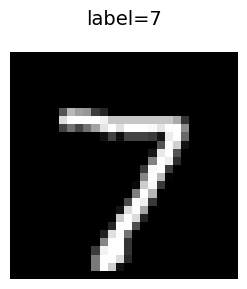

In [5]:
image_index = 0
xlab.utils.show_grayscale_image(mnist_images[image_index], title=f"label={mnist_labels[image_index]}")

In [3]:
import xlab
from xlab.models import BlackBox

# Load the black box model (downloads automatically)
model = xlab.utils.load_black_box_model('mnist-black-box')

# Make predictions (model details are hidden)
predictions = model.predict(mnist_images)
probabilities = model.predict_proba(mnist_images)

# Can also use it like a function
predictions = model(mnist_images)

In [4]:
predictions

tensor([7, 2, 1, 0, 4, 1, 4, 9, 5, 9, 0, 6, 9, 0, 1, 5, 9, 7, 3, 4, 9, 6, 6, 5,
        4, 0, 7, 4, 0, 1, 3, 1, 3, 0, 7, 2, 7, 1, 2, 1, 1, 7, 4, 2, 3, 5, 1, 2,
        4, 4, 6, 3, 5, 5, 6, 0, 4, 1, 9, 5, 7, 8, 9, 3, 7, 4, 6, 4, 3, 0, 7, 0,
        2, 9, 1, 7, 3, 2, 9, 7, 7, 6, 2, 7, 8, 4, 7, 3, 6, 1, 3, 6, 9, 3, 1, 4,
        1, 7, 6, 9])

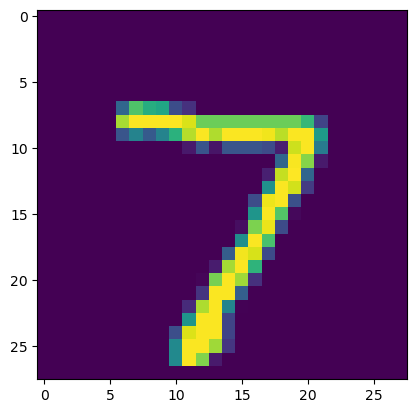

In [12]:
plt.imshow(mnist_images[0][0])

In [3]:
from huggingface_hub import hf_hub_download
from xlab.models import ConvolutionalMNIST

# https://huggingface.co/uchicago-xlab-ai-security/tiny-wideresnet-cifar10
model_path = hf_hub_download(
    repo_id="uchicago-xlab-ai-security/mnist-ensemble",
    filename="mnist_simple_cnn.pth"
)
model = torch.load(model_path, map_location='cpu', weights_only=False)
_ = model.eval()

mnist_simple_cnn.pth:   0%|          | 0.00/432k [00:00<?, ?B/s]

In [3]:
model(mnist_images[0:1])

NameError: name 'model' is not defined

In [4]:
from huggingface_hub import hf_hub_download
from xlab.models import ResNetMNIST, BasicBlockMNIST

# https://huggingface.co/uchicago-xlab-ai-security/tiny-wideresnet-cifar10
model_path = hf_hub_download(
    repo_id="uchicago-xlab-ai-security/mnist-ensemble",
    filename="mnist_wideresnet.pth"
)
model = torch.load(model_path, map_location='cpu', weights_only=False)
_ = model.eval()


mnist_wideresnet.pth:   0%|          | 0.00/693k [00:00<?, ?B/s]

In [5]:
model(mnist_images[0:1])

tensor([[-8.7614, -0.1434, -2.2696, -2.6548, -0.9835, -6.6371, -9.8690,  6.9030,
         -8.5592,  0.1233]], grad_fn=<AddmmBackward0>)

In [3]:
from huggingface_hub import hf_hub_download
from xlab.models import FeedforwardMNIST

# https://huggingface.co/uchicago-xlab-ai-security/tiny-wideresnet-cifar10
model_path = hf_hub_download(
    repo_id="uchicago-xlab-ai-security/mnist-ensemble",
    filename="mnist_mlp.pth"
)
model = torch.load(model_path, map_location='cpu', weights_only=False)
_ = model.eval()

mnist_mlp.pth:   0%|          | 0.00/166k [00:00<?, ?B/s]

In [4]:
model(mnist_images[0:1])

tensor([[ -0.2652, -10.5678,   0.7676,   4.0928, -10.3465,   0.0514, -15.9896,
           9.2350,  -2.0897,   2.2656]], grad_fn=<AddmmBackward0>)